# TODOs
- [X] send email to Errol - does the team that installed an asset do all other maintenance related events for the same asset? Useful for determining team productivity and effectiveness.
- [X] Meaning of previous_repairs and previous_unplanned in assets table.
At first it seemed that it was simply the values of the last row from the events table, but it doesn't seem to match up.
- [ ] Meaning of non-zero previous_repairs and previous_unplanned in first event after installation.
- [X] Transform datetimes and time periods to numeric data
- [X] Augment assets data with events statistics: number of replacements, number of repairs, average time between events, ...?
- [ ] Save the samples that are not included for the model training and testing (from the down sampling) and use them for testing. Will make a very large test set.


`01MAI`
- Trained the dataset with a Random Forest Classifier on the horizon 30 class. Very high accuracy.
- Looked at the class distribution and observed that it was very imbalanced.
- Downsamples to have a 50/50 split.
- Retrained. Very high accuracy.


Source:
- Predicteve maintenance
  - [predictive maintenance article - towardsdatascience](https://towardsdatascience.com/how-to-implement-machine-learning-for-predictive-maintenance-4633cdbe4860)
- Imbalanced data
  - [dealing with imbalanced class distribution](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/)
  - [what is imbalanced data](https://machinelearningmastery.com/what-is-imbalanced-classification/)

# Predictive Maintenance Exploration

# Introduction

This notebook presents:
- the exploration of the problem data,
- proposes several strategies of using this data to increase business value,
- implements two of these strategies
  - by predicting occurrence of maintenance events
  - predicting Remaining Useful Life of assets
- recommends ways to improve the models in the future

It's divided in 3 chapters:
1. Data exploration: What data do we have? Do we have outliers? How to join the data? What kinds of data do we have?
2. Data analysis: What is the distribution of the data? What does it mean? How is it correlated? How can it be augmented? What influences event occurrence? What influences team performance?
3. Predictive maintenance pipline: Create dataset for models; Train models for strategy 1; Train models for strategy 2.

In [106]:
# staDecisionTreeClassifierd library
from typing import List, Union, Optional, Tuple
import datetime
from collections import namedtuple

# data and viz
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# numeric
import math
import numpy as np

# data prep
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

# models
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC

# metrics
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import tree

# prod
from urllib.parse import urlparse
import mlflow
import mlflow.sklearn

# 1. Data exploration

## 1.1. Load data

In [2]:
datafiles = !ls data/*

In [3]:
datasets = {}
for fn in datafiles:
    dataset_name = fn.split('/')[-1].rstrip('.csv')
    datasets[dataset_name] = pd.read_csv(fn)

for name, dataset in datasets.items():
    print('\n'*3, name, '\n')
    print(dataset)




 asset_attribute_data_general 

     asset_id asset_install_team  asset_line asset_material
0    A:cpjwvv              team4   east_line           iron
1    A:xoauw0              team3  south_line          steel
2    A:xpqps2              team1   east_line           iron
3    A:m44bmt              team4   west_line          steel
4    A:rwkyh1              team2  north_line          steel
..        ...                ...         ...            ...
195  A:271d3q              team4  south_line           iron
196  A:6tjk91              team3   west_line           iron
197  A:j9z5oa              team2   east_line           iron
198  A:100egl              team2   west_line          alloy
199  A:bo36ea              team1  south_line          steel

[200 rows x 4 columns]



 asset_attribute_data_usage 

     asset_id  asset_trains_per_hour
0    A:cpjwvv                    2.0
1    A:xoauw0                    4.0
2    A:xpqps2                    4.0
3    A:m44bmt                    4.0
4  

In [4]:
(datasets['replacement_data'].shape[0] + datasets['repair_data'].shape[0]) == datasets['planned_data'].shape[0]

True

The planned data seems to contain all the repair and replacement events.

## 1.2. Join all datasets in 2 tables (events, assets)

We seem to have 2 types of data. We'll start the process of combining all tables into 2 tables for each of these types:
- time series data for maintenance events ("events");
- and assets' attributes data ("assets").



### 1.2.1. Join events

To combine these tables, we will:
1. We'll need to first add a column to repair_data and replacement_data to indicate the type of event.
2. All columns are the same, so we can concatenate repair and replacement events.
3. Inner join events with planned data. We just need the planned column.

Let's call this new dataset "events".

In [5]:
datasets['replacement_data']['type'] = 'replacement'
datasets['repair_data']['type'] = 'repair'

In [6]:
datasets['all_events_data'] = pd.concat([datasets['replacement_data'], datasets['repair_data']])

In [7]:
events = pd.merge(datasets['all_events_data'], datasets['planned_data'], how='inner', on=['event_id', 'asset_id', 'event_date'])

In [8]:
date_cols = ['event_date', 'installed_date']
for col in date_cols:
    events[col] = pd.to_datetime(events[col])

In [9]:
events.sort_values(by=['asset_id', 'event_date'])

,asset_id,event_date,event_id,installed_date,previous_repairs,previous_unplanned,type,planned
1971,A:05y6pa,2008-11-26,E:a6p6ral8ln,2006-08-07,1,1,repair,False
1066,A:05y6pa,2009-03-25,E:krdug1zk4k,2008-11-26,0,0,replacement,False
1067,A:05y6pa,2009-12-01,E:k2aq31j1u8,2009-03-25,0,0,replacement,False
1068,A:05y6pa,2010-11-11,E:3980fazvgf,2009-12-01,0,0,replacement,False
1069,A:05y6pa,2011-03-03,E:10yy8t172l,2010-11-11,0,0,replacement,True
...,...,...,...,...,...,...,...,...
780,A:zntvay,2001-01-01,E:bbhbqt4au1,2000-04-25,0,0,replacement,False
1721,A:zntvay,2001-06-29,E:3au1t05cgq,2001-01-01,1,1,repair,False
781,A:zntvay,2001-11-26,E:0mb9fxiwzv,2001-06-29,0,0,replacement,False
782,A:zntvay,2002-07-30,E:9ap7nmcap2,2001-11-26,0,0,replacement,False


### 1.2.2 Join assets

Let's join the attributes of the assets in a single table:
- asset_attribute_data_general
- asset_attribute_data_usage
- asset_attribute_data_weather
- asset_data

Let's call this new dataset "assets".

In [10]:
assets = pd.merge(datasets['asset_attribute_data_general'], datasets['asset_attribute_data_usage'], on='asset_id')
assets = pd.merge(assets, datasets['asset_attribute_data_weather'], on='asset_id')
assets = pd.merge(assets, datasets['asset_data'], on='asset_id')

In [11]:
date_cols = ['end_date', 'start_date']
for col in date_cols:
    assets[col] = pd.to_datetime(assets[col])

In [12]:
assets['total_useful_life'] = assets['end_date'] - assets['start_date']

In [13]:
assets = assets.rename(columns={'previous_repairs': 'start_previous_repairs',
               'previous_unplanned': 'start_previous_unplanned'})

## 1.3. Check for gaps in datasets

Now we have only 2 tables to work with. One refers to data about maintenance events, the other about asset attributes.

Let's check if there are gaps in the data:
- Do all assets have maintenance events? If not, why?
- Are there events refering to missing assets? These might need to be discarded depending on the following analysis.

In [14]:
# do all assets have maintenance events?
assets_that_broke = events['asset_id'].unique()
print(f'{len(assets_that_broke)}\t assets that have replacement or repair events')

print(f'{assets.shape[0]}\t assets')

assets_without_events = assets[assets['asset_id'].isin(assets_that_broke) == False]
print(f'{assets_without_events.shape[0]}\t assets without events')

194	 assets that have replacement or repair events
200	 assets
6	 assets without events


In [15]:
assets_without_events

,asset_id,asset_install_team,asset_line,asset_material,asset_trains_per_hour,asset_weather_cluster,end_date,latitude,longitude,start_previous_repairs,start_previous_unplanned,start_date,total_useful_life
10,A:vxsw13,team4,east_line,alloy,4.0,standard,2001-12-29,51.023245,-1.510241,0,0,2000-10-19,436 days
107,A:yms563,team1,west_line,steel,4.0,rain,2016-02-08,51.681039,-1.295413,0,0,2015-04-23,291 days
129,A:hxplmb,team2,north_line,iron,1.0,heavy_rain,2005-08-24,56.908365,-4.271977,0,0,2005-01-08,228 days
154,A:g0tw27,team2,west_line,alloy,4.0,standard,2004-11-03,53.085183,-0.969012,0,0,2004-05-10,177 days
163,A:xonk3o,team1,south_line,alloy,8.0,standard,2014-11-07,53.267591,-1.161464,0,6,2014-06-06,154 days
186,A:a46une,team2,west_line,steel,16.0,rain,2015-05-09,51.014137,-1.640571,0,0,2015-01-14,115 days


In [16]:
assets.describe()

,asset_trains_per_hour,latitude,longitude,start_previous_repairs,start_previous_unplanned,total_useful_life
count,200.000000,200.000000,200.000000,200.000000,200.000000,200
mean,7.560000,54.129910,-2.669047,0.055000,0.875000,1530 days 20:52:48
std,7.569205,2.151421,1.444446,0.228552,2.288133,981 days 15:59:07.628708096
min,1.000000,50.540986,-4.982743,0.000000,0.000000,104 days 00:00:00
25%,4.000000,52.308350,-3.966266,0.000000,0.000000,697 days 00:00:00
50%,4.000000,54.046565,-2.696665,0.000000,0.000000,1349 days 12:00:00
75%,8.000000,55.764131,-1.576007,0.000000,0.000000,2291 days 06:00:00
max,32.000000,58.420153,0.444095,1.000000,9.000000,3579 days 00:00:00


Of the 200 registered assets, we have maintenance events on 194.
Looking at the data from the 6 that didn't have incidents, no pattern is identified about their attributes.
Different teams installed them, they have different materials, locations, weather and were operational on different years.
The only similarity is that all these assets have a total useful life well below the 25% percentile.
However, there are assets that had a shorter useful life and still had maintenance events.

Let's check the statistics for time between events to decide whether to consider that these 6 assets are outliers and exclude them from further exploration.

installed_date is the date of the last intervention, either installation, which matches the start_date in the assets table, or the last repair or replacement.

In [17]:
events['time_since_last_event'] = events['event_date'] - events['installed_date']

In [18]:
events['time_since_last_event'].describe()

count                           2032
mean     135 days 18:32:35.905511812
std      148 days 13:41:11.589129062
min                  0 days 00:00:00
25%                 37 days 00:00:00
50%                 90 days 00:00:00
75%                181 days 06:00:00
max               1385 days 00:00:00
Name: time_since_last_event, dtype: object

In [19]:
q = 0.9
print(events['time_since_last_event'].quantile(q))
print(f'# events over quantile {q}: {2032*(1-q)}')

321 days 00:00:00
# events over quantile 0.9: 203.19999999999996


For 10% of events (~203 events), the time elapsed since the previous event was higher than 321 days.
Of the 6 assets than didn't have events, 5 have a useful life below 300 days.
This means that it's plausible that these 6 assets didn't have any maintenance events, given their brief useful life, and we'll reject the hypothesis that it's due to missing data in the events table


They will not be removed from the analysis when considering only assets' attributes.

## 1.4. Data Strategy

The events and assets tables are two different kinds of data and we can use them to answer lots of questions.
1. Which asset attributes are correlated with number of maintenance events?
2. Which attributes are correlated with total useful life?
3. Are there better performing teams?
4. Should we be avoiding certain materials in specific locations or weather clusters?
5. Can we predict the remaining useful life of an asset within several given time horizons (e.g. 30, 90, 180 days)?

In section 2., we'll use the events data to augment the assets table and gather as much insights as possible about questions 1-4, and others that might arise during analysis.

These insights will be used to guide question 5, in section 3.
There, we'll build and describe a functional pipeline to predict approximate remaining useful life for each asset.
**This pipeline can then be used in production, informing management decisions and guiding operation and maintenance teams in the field for reducing costs and downtime, and increase team productivity and customer satisfaction.**


# 2. Data analysis

## 2.1. Transforming features

### 2.1.1. Transforming categorical features

For computing the correlation of the different features, we have to transform some of them.
Specifically, we'll need to transform categorical features (team, line, material).

Let's make a copy of the original assets table and apply this transformation.

In [20]:
assets2 = assets.copy()
events2 = events.copy()

In [21]:
assets2 = pd.get_dummies(assets2, columns=['asset_material', 'asset_line', 'asset_weather_cluster', 'asset_install_team', 'asset_weather_cluster'])
events2 = pd.get_dummies(events2, columns=['type', 'planned'])

In [22]:
assets2

,asset_id,asset_trains_per_hour,end_date,latitude,longitude,start_previous_repairs,start_previous_unplanned,start_date,total_useful_life,asset_material_alloy,...,asset_weather_cluster_sun,asset_install_team_team1,asset_install_team_team2,asset_install_team_team3,asset_install_team_team4,asset_weather_cluster_heavy_rain,asset_weather_cluster_rain,asset_weather_cluster_snow,asset_weather_cluster_standard,asset_weather_cluster_sun
0,A:cpjwvv,2.0,2012-02-26,51.108966,-1.382032,0,0,2008-06-26,1340 days,0,...,0,0,0,0,1,0,0,0,1,0
1,A:xoauw0,4.0,2005-03-01,58.369692,-4.982743,0,0,2003-06-08,632 days,0,...,0,0,0,1,0,0,0,0,1,0
2,A:xpqps2,4.0,2009-10-27,55.759249,-4.593591,0,0,2007-03-03,969 days,0,...,1,1,0,0,0,0,0,0,0,1
3,A:m44bmt,4.0,2008-02-23,52.289685,-1.418834,0,0,2007-01-17,402 days,0,...,1,0,0,0,1,0,0,0,0,1
4,A:rwkyh1,1.0,2013-06-21,55.686979,-4.542553,0,0,2012-06-03,383 days,0,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,A:271d3q,4.0,2012-05-12,52.883360,-2.048643,0,0,2005-10-15,2401 days,0,...,0,0,0,0,1,0,0,0,1,0
196,A:6tjk91,4.0,2016-07-08,54.765397,-2.104487,0,0,2013-08-22,1051 days,0,...,0,0,0,1,0,0,0,0,1,0
197,A:j9z5oa,8.0,2017-06-01,54.332715,-2.370033,0,0,2013-05-21,1472 days,0,...,0,0,1,0,0,1,0,0,0,0
198,A:100egl,2.0,2013-08-18,54.151059,-2.068212,0,0,2008-05-04,1932 days,1,...,1,0,1,0,0,0,0,0,0,1


### 2.1.2. Describing `previous_repairs` and `previous_unplanned`

The `previous_repairs` and `previous_unplanned` columns are present both in the events and assets tables.

In [23]:
events[events['asset_id'] == 'A:xoauw0'] .sort_values('event_date')

,asset_id,event_date,event_id,installed_date,previous_repairs,previous_unplanned,type,planned,time_since_last_event
12,A:xoauw0,2003-07-26,E:s08alqo9vd,2003-06-08,0,0,replacement,False,48 days
13,A:xoauw0,2003-08-28,E:ws1vyy7oao,2003-07-26,0,0,replacement,False,33 days
1174,A:xoauw0,2004-05-10,E:8h4dpsljy3,2003-08-28,1,1,repair,False,256 days
1175,A:xoauw0,2004-10-18,E:zl0sp2rps7,2004-05-10,2,2,repair,False,161 days
14,A:xoauw0,2005-01-18,E:uxv1ak7npw,2004-10-18,0,0,replacement,False,92 days
15,A:xoauw0,2005-02-09,E:3ijuweltm9,2005-01-18,0,0,replacement,False,22 days


`events`

After studying the events sequence for several assets, the following was concluded.
- In the events table, the previous_repairs column contains how many repair events ocurred since the last replacement event.
- The previous_unplanned contains how many unplanned repair events occurred snce the last replacement event.
- Each time a replacement happens, both counters are reset to 0.

In [24]:
assets[assets['start_previous_unplanned'] > 0].head()

,asset_id,asset_install_team,asset_line,asset_material,asset_trains_per_hour,asset_weather_cluster,end_date,latitude,longitude,start_previous_repairs,start_previous_unplanned,start_date,total_useful_life
8,A:k1vxf4,team2,east_line,alloy,4.0,sun,2013-12-31,54.130786,-2.228854,0,7,2005-02-11,3245 days
20,A:z7x72w,team3,east_line,alloy,2.0,rain,2008-01-29,57.061845,-4.082603,0,6,2004-07-18,1290 days
22,A:32x8eq,team1,east_line,iron,4.0,standard,2017-06-01,54.402162,-2.968634,0,1,2015-08-13,658 days
28,A:yual0k,team2,north_line,alloy,4.0,standard,2017-03-31,57.409986,-3.954359,0,2,2007-07-26,3536 days
31,A:s7m6fn,team3,west_line,iron,32.0,standard,2008-04-20,51.397790,-0.407790,0,3,2004-02-19,1522 days


In [25]:
asset_id = 'A:z7x72w'

In [26]:
assets[assets['asset_id'] == asset_id]

,asset_id,asset_install_team,asset_line,asset_material,asset_trains_per_hour,asset_weather_cluster,end_date,latitude,longitude,start_previous_repairs,start_previous_unplanned,start_date,total_useful_life
20,A:z7x72w,team3,east_line,alloy,2.0,rain,2008-01-29,57.061845,-4.082603,0,6,2004-07-18,1290 days


In [27]:
events[events['asset_id'] == asset_id] .sort_values('event_date')

,asset_id,event_date,event_id,installed_date,previous_repairs,previous_unplanned,type,planned,time_since_last_event
1261,A:z7x72w,2004-12-19,E:hlcngqiiwq,2004-07-18,1,7,repair,False,154 days
123,A:z7x72w,2004-12-22,E:las3bka49y,2004-12-19,0,0,replacement,False,3 days
124,A:z7x72w,2005-04-22,E:0x4y0hncm6,2004-12-22,0,0,replacement,False,121 days
1262,A:z7x72w,2005-09-03,E:pu89wkwy89,2005-04-22,1,1,repair,False,134 days
125,A:z7x72w,2007-02-01,E:2bqezyewhl,2005-09-03,0,0,replacement,False,516 days
1263,A:z7x72w,2007-02-05,E:qc4q8w3y1o,2007-02-01,1,1,repair,False,4 days
1264,A:z7x72w,2007-04-02,E:ci9ve4iz14,2007-02-05,2,1,repair,True,56 days
1265,A:z7x72w,2007-07-30,E:5mshw3wdb7,2007-04-02,3,2,repair,False,119 days
126,A:z7x72w,2007-09-25,E:sonk4pzybh,2007-07-30,0,0,replacement,False,57 days
1266,A:z7x72w,2008-01-18,E:refryds8fc,2007-09-25,1,1,repair,False,115 days


`assets`
After studying the events sequence for several assets and their corresponding assets row, the following was concluded:
- The previous_repairs and previous_unplanned features of the assets table represen the total number repairs and number of unplanned repairs since the last replacement, at the moment of installation.
- This can be observed, for example, in the data regarding the asset with ID "A:z7x72w".
  - previous_repairs is 0 and previous_unplanned is 6 in the assets table. The first event is an unplanned repair. Both counters are incremented in the events table.
- It should be noted that in the events table, previous_unplanned is always lower than previous_repairs, but in the assets table such is not the case.

### 2.1.3 Transforming dates and time periods

We'll also need to transform features containing dates and time durations, because datetimes and timedeltas can't be directly correlated with other numeric data.

- We'll make a feature from the year to try to understand if older installations are less reliable.
- We'll use the month and day to make a sinusoidal wave with a period of one year and no phase shift, to understand if the seasons and time of the year also has an influence.*
  - We use a sinusoid so that the last days from one year are similar to the first days from the following year.
- We'll also add a weekday categorical variable (one hot encoded) to see understand if more 

\* [method for convertion](https://math.stackexchange.com/a/650235)

In [28]:
def day_of_year_to_sin(day: pd.Timestamp,
                       period: float = 365.0,
                       phase_shift: float = 84.0):
    '''
    day: a pandas timestamp
    period: specifies the period of the wave
    phase_shift: shifts the sine wave so the the peaks are at specific days, 84 makes the peak ~match the solstice
    '''
    return math.sin((2 * math.pi) / period * (day.day_of_year - phase_shift))
    

weekdays = {0: 'monday',
            1: 'tuesday',
            2: 'wednesday',
            3: 'thursday',
            4: 'friday',
            5: 'saturday',
            6: 'sunday'
           }

def augment_datetime(df: pd.DataFrame, columns: List[str]):
    '''
    for each pandas.Timestamp column in dataframe df, create 3 features:
    - year (integer)
    - sine wave (from day and month) with yearly period
    - weekday, one hot encoded
    for each pandas.Timedelta column, convert to integer in days
    
    :returns: the input with 
    '''
    df_copy = df.copy()
    for col in columns:
        if col not in df_copy:
            raise Exception(f'column {col} not present in dataframe')
            
        if isinstance(df_copy[col].iloc[0], pd.Timestamp):
            df_copy[col + '_year'] = df_copy[col].map(lambda d: d.year)
            df_copy[col + '_weekday'] = df_copy[col].map(lambda d: weekdays[d.day_of_week])
            df_copy[col + '_sin_year'] = df_copy[col].map(day_of_year_to_sin)
            
            df_copy = pd.get_dummies(df_copy, columns=[col + '_weekday'])
            
        elif isinstance(df[col].iloc[0], pd.Timedelta):
            df_copy[col + '_days_int'] = df_copy[col].map(lambda td: td.days)
            
        else:
            raise TypeError(f'{col} is not of type pandas.Timestamp or pandas.Timedelta')
            
    return df_copy

In [29]:
assets2 = augment_datetime(assets2, ['end_date', 'start_date', 'total_useful_life'])
events2 = augment_datetime(events2, ['event_date', 'installed_date', 'time_since_last_event'])

## 2.2. Data augmentation

Let's augment the assets table with events statistics.

In [30]:
# create columns with default value 0, because of the 6 assets that don't have reported events
assets2['total_repairs'] = 0
assets2['total_replacements'] = 0

assets2['total_unplanned_repairs'] = 0
assets2['total_unplanned_replacements'] = 0

assets2['average_time_between_events'] = 0
assets2['std_time_between_events'] = 0

assets2 = assets2.set_index('asset_id')

events2['unplanned_repairs'] = events2['type_repair'] * events2['planned_False']
events2['unplanned_replacements'] = events2['type_replacement'] * events2['planned_False']


asset_group = events2.groupby('asset_id')

assets2['total_repairs'] = asset_group['type_repair'].sum()
assets2['total_replacements'] = asset_group['type_replacement'].sum()
assets2['average_time_between_events'] = asset_group['time_since_last_event_days_int'].mean()
assets2['std_time_between_events'] = asset_group['time_since_last_event_days_int'].std()


assets2['total_unplanned_repairs'] = asset_group['unplanned_repairs'].sum()
assets2['total_unplanned_replacements'] = asset_group['unplanned_replacements'].sum()

events2.drop(columns=['unplanned_repairs', 'unplanned_replacements'])

assets2[['total_repairs','total_replacements',
         'average_time_between_events',
         'std_time_between_events',
         'total_unplanned_repairs',
         'total_unplanned_replacements']]

,total_repairs,total_replacements,average_time_between_events,std_time_between_events,total_unplanned_repairs,total_unplanned_replacements
asset_id,,,,,,
A:cpjwvv,1.0,12.0,85.076923,95.283316,1.0,11.0
A:xoauw0,2.0,4.0,102.000000,90.965928,2.0,4.0
A:xpqps2,1.0,2.0,306.333333,349.299776,1.0,2.0
A:m44bmt,2.0,3.0,74.000000,72.763315,2.0,3.0
A:rwkyh1,2.0,3.0,39.000000,27.703790,2.0,3.0
...,...,...,...,...,...,...
A:271d3q,6.0,12.0,132.611111,117.183184,6.0,7.0
A:6tjk91,1.0,4.0,92.400000,35.507746,1.0,4.0
A:j9z5oa,4.0,7.0,127.000000,137.472906,3.0,6.0


## 2.3. Results and interpretation

In [31]:
def corr_filter(df: pd.DataFrame,
                column: str,
                threshold: float = 0.2) -> pd.Series:
    corr = df.corr()[column]
    return corr[(corr <= -threshold) | (corr >= threshold)].sort_values()

### 2.3.1. How is the data distributed?

#### 2.3.1.1. Events types

The vast majority of events are unplanned $85\%$, for both repairs and replacements ($33\%$ and $52$, respectively).
The number of replacements ($57\%$) is slightly higher than that of repairs ($43\%$).

In [32]:
events.groupby(['type', 'planned']).count()['asset_id'] / events.shape[0] * 100

type         planned
repair       False      33.415354
             True        8.858268
replacement  False      52.362205
             True        5.364173
Name: asset_id, dtype: float64

Text(0, 0.5, '# events')

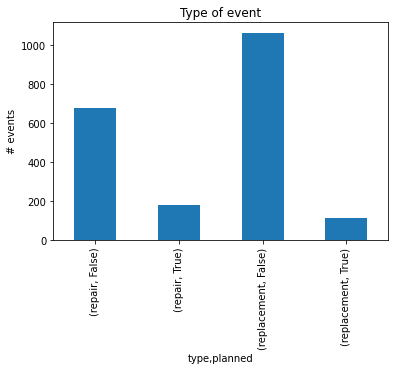

In [33]:
events.groupby(['type', 'planned']).count()['asset_id'].plot(kind='bar')

plt.title('Type of event')
plt.ylabel('# events')

#### 2.3.1.2. Asset line, weather, material

`weather clusters`
- A "standard" weather cluster accounts for most of the assets ($46\%$), but for the remaining clusters the assets are fairly well distributed.
- Useful life for heavy rain is lower than for the other weather clusters, and highest for sun.
However, the usage for heavy rain is highest and lowest for sun.
This means we cannot conclude right away that it's a particular weather cluster that is having an influence on useful life.

`asset lines`
- Assets' distribution over asset lines is almost uniform.
- Useful life is slightly higher for east and south lines.
Again, these lines have a lower usage.

`asset materials`
- Assets' distribution over materials is close to uniform.
- Steel has a slightly lower useful life, but is one of the materials with highest usage, so it makes sense.
- Iron has a high useful life, even though it has a high usage, which is an interesting result.
- Material variations for both usage and useful life are lower when compared to other variables.
For this reason, high confidence conclusions should not be drawn. 


In [34]:
assets['total_useful_life'] = assets['total_useful_life'].map(lambda x: x.days)

In [35]:
mean_useful_life = assets['total_useful_life'].mean()
print(f'average useful life: {mean_useful_life}')

average useful life: 1530.87


Text(0, 0.5, '')

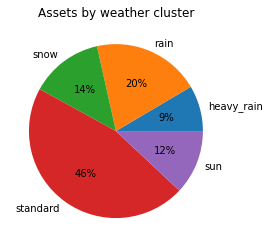

In [36]:
assets.groupby('asset_weather_cluster')['asset_id'].count().plot(kind='pie', autopct='%1.f%%')
plt.title('Assets by weather cluster')
plt.ylabel('')

Text(0, 0.5, 'hours')

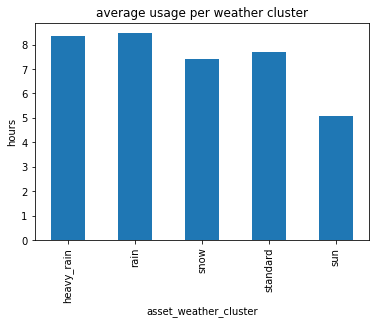

In [37]:
assets.groupby('asset_weather_cluster')['asset_trains_per_hour'].mean().plot(kind='bar')
plt.title('average usage per weather cluster')
plt.ylabel('hours')

Text(0, 0.5, 'days')

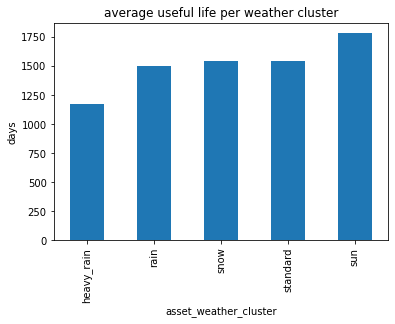

In [38]:
assets.groupby('asset_weather_cluster')['total_useful_life'].mean().plot(kind='bar')
plt.title('average useful life per weather cluster')
plt.ylabel('days')

Text(0, 0.5, '')

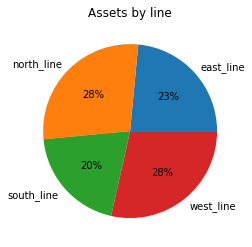

In [39]:
assets.groupby('asset_line')['asset_id'].count().plot(kind='pie', autopct='%1.f%%')
plt.title('Assets by line')
plt.ylabel('')

Text(0, 0.5, 'hours')

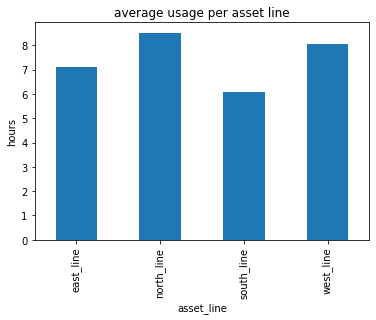

In [40]:
assets.groupby('asset_line')['asset_trains_per_hour'].mean().plot(kind='bar')
plt.title('average usage per asset line')
plt.ylabel('hours')

Text(0, 0.5, 'days')

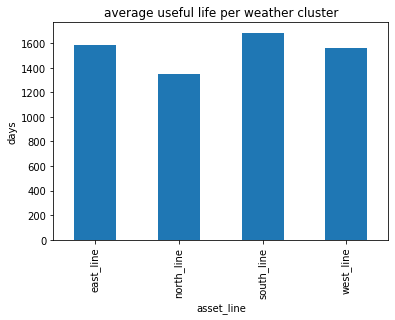

In [41]:
assets.groupby('asset_line')['total_useful_life'].mean().plot(kind='bar')
plt.title('average useful life per weather cluster')
plt.ylabel('days')

Text(0, 0.5, '')

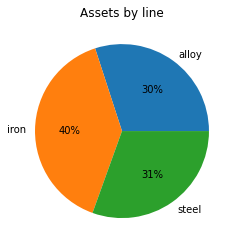

In [42]:
assets.groupby('asset_material')['asset_id'].count().plot(kind='pie', autopct='%1.f%%')
plt.title('Assets by line')
plt.ylabel('')

Text(0, 0.5, 'hours')

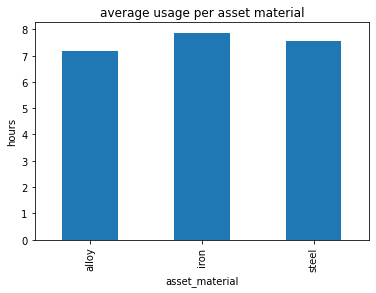

In [43]:
assets.groupby('asset_material')['asset_trains_per_hour'].mean().plot(kind='bar')
plt.title('average usage per asset material')
plt.ylabel('hours')

Text(0, 0.5, 'days')

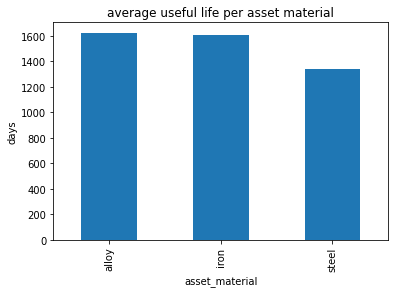

In [44]:
assets.groupby('asset_material')['total_useful_life'].mean().plot(kind='bar')
plt.title('average useful life per asset material')
plt.ylabel('days')

#### 2.3.1.3. Asset usage

Since asset usage is distributed over a small set of values, we can plot this variable against others and try to understand some patterns. Asset usage was already studied above, so we'll analyze other relationships in these section.

- Surprisingly, useful life doesn't decrease linearly with increasing asset usage (inverse relationship).
This suggests that useful life has several different contributing factors.
- The number of maintenance events is higher for higher usage, which would be expected.


Text(0, 0.5, 'days')

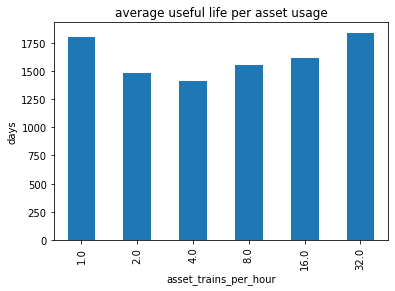

In [45]:
assets.groupby('asset_trains_per_hour')['total_useful_life'].mean().plot(kind='bar')
plt.title('average useful life per asset usage')
plt.ylabel('days')

Text(0, 0.5, '# events')

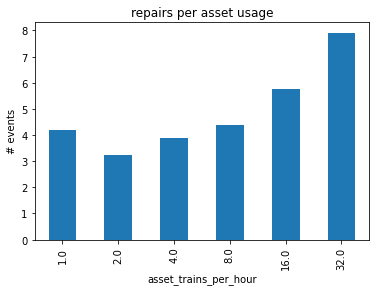

In [46]:
assets2.groupby('asset_trains_per_hour')['total_repairs'].mean().plot(kind='bar')
plt.title('repairs per asset usage')
plt.ylabel('# events')

Text(0, 0.5, '# events')

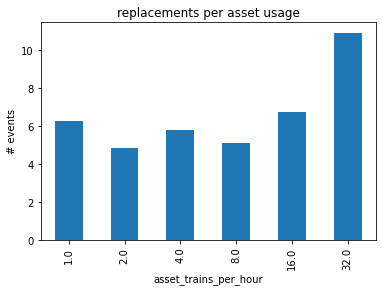

In [47]:
assets2.groupby('asset_trains_per_hour')['total_replacements'].mean().plot(kind='bar')
plt.title('replacements per asset usage')
plt.ylabel('# events')

### 2.3.2. What influences total useful life?

In [48]:
corr_filter(assets2, 'total_useful_life_days_int', threshold=0.2)

start_date_year                -0.413957
std_time_between_events         0.285796
total_unplanned_repairs         0.702832
total_unplanned_replacements    0.733742
total_repairs                   0.744405
total_replacements              0.757430
total_useful_life_days_int      1.000000
Name: total_useful_life_days_int, dtype: float64

- There is very week correlation between useful life and most other variables.
- start_date has a strong correlation, but this likely means that the assets that were installed earlier have a better change to be represented longer in the events table.
- The number of events (repair and replacements) is also strongly correlated.
Again, an asset that is active for a long time is more likely to have more maintenance incidents, so this is to be expected.

### 2.3.3. What influences occurence of maintenance events?

In [49]:
corr_filter(assets2, 'total_repairs', threshold=0.2)

start_date_year                -0.342115
end_date_weekday_thursday      -0.244409
average_time_between_events    -0.231829
asset_trains_per_hour           0.280233
total_unplanned_replacements    0.704130
total_replacements              0.719140
total_useful_life_days_int      0.744405
total_unplanned_repairs         0.966309
total_repairs                   1.000000
Name: total_repairs, dtype: float64

In [50]:
corr_filter(assets2, 'total_replacements', threshold=0.2)

start_date_year                -0.341005
average_time_between_events    -0.244952
asset_trains_per_hour           0.259736
total_repairs                   0.719140
total_unplanned_repairs         0.719675
total_useful_life_days_int      0.757430
total_unplanned_replacements    0.981730
total_replacements              1.000000
Name: total_replacements, dtype: float64

In [51]:
corr_filter(assets2, 'total_unplanned_repairs', threshold=0.2)

start_date_year                -0.341496
average_time_between_events    -0.243830
end_date_weekday_thursday      -0.233442
asset_trains_per_hour           0.308930
total_useful_life_days_int      0.702832
total_unplanned_replacements    0.715569
total_replacements              0.719675
total_repairs                   0.966309
total_unplanned_repairs         1.000000
Name: total_unplanned_repairs, dtype: float64

In [52]:
corr_filter(assets2, 'total_unplanned_replacements', threshold=0.2)

start_date_year                -0.328015
average_time_between_events    -0.239596
asset_trains_per_hour           0.286509
total_repairs                   0.704130
total_unplanned_repairs         0.715569
total_useful_life_days_int      0.733742
total_replacements              0.981730
total_unplanned_replacements    1.000000
Name: total_unplanned_replacements, dtype: float64

In [53]:
corr_filter(assets2, 'total_unplanned_repairs', threshold=0.2)

start_date_year                -0.341496
average_time_between_events    -0.243830
end_date_weekday_thursday      -0.233442
asset_trains_per_hour           0.308930
total_useful_life_days_int      0.702832
total_unplanned_replacements    0.715569
total_replacements              0.719675
total_repairs                   0.966309
total_unplanned_repairs         1.000000
Name: total_unplanned_repairs, dtype: float64

In [54]:
events2.corr()['type_repair'].sort_values()

type_replacement                   -1.000000
unplanned_replacements             -0.897182
planned_False                      -0.164941
event_date_weekday_thursday        -0.043324
time_since_last_event_days_int     -0.027812
event_date_year                    -0.024429
event_date_weekday_sunday          -0.022158
installed_date_year                -0.020312
installed_date_weekday_sunday      -0.019920
installed_date_weekday_thursday    -0.013538
installed_date_weekday_wednesday   -0.006839
installed_date_sin_year            -0.005532
installed_date_weekday_friday      -0.002470
event_date_weekday_monday           0.002709
event_date_weekday_wednesday        0.007575
installed_date_weekday_monday       0.008070
event_date_weekday_tuesday          0.010129
installed_date_weekday_saturday     0.013393
event_date_weekday_friday           0.019637
installed_date_weekday_tuesday      0.021002
event_date_sin_year                 0.022103
event_date_weekday_saturday         0.025183
planned_Tr

### 2.3.4. Team performance

**Assumption: the team that installed a particular asset is also the team that performed all repairs and replacements for that same asset throughout its useful life.**

- Assets are well distributed over teams (close to uniform).
- Events are well distributed over teams.
Teams with more assets have more events.
- The percentage of unplanned events is very close for all teams.
- There is little variability within useful life, among teams.
Of note, team 2 has a slightly lower average asset useful life, even though it has the lowest average asset usage, which would be more surprising, if values varied significantly.
- The conclusion is that the effectiveness and relative competence of teams is the same.

In [55]:
assets2['team'] = assets.set_index('asset_id')['asset_install_team']
assets2.head()

,asset_trains_per_hour,end_date,latitude,longitude,start_previous_repairs,start_previous_unplanned,start_date,total_useful_life,asset_material_alloy,asset_material_iron,...,start_date_weekday_tuesday,start_date_weekday_wednesday,total_useful_life_days_int,total_repairs,total_replacements,total_unplanned_repairs,total_unplanned_replacements,average_time_between_events,std_time_between_events,team
asset_id,,,,,,,,,,,,,,,,,,,,,
A:cpjwvv,2.0,2012-02-26,51.108966,-1.382032,0,0,2008-06-26,1340 days,0,1,...,0,0,1340,1.0,12.0,1.0,11.0,85.076923,95.283316,team4
A:xoauw0,4.0,2005-03-01,58.369692,-4.982743,0,0,2003-06-08,632 days,0,0,...,0,0,632,2.0,4.0,2.0,4.0,102.000000,90.965928,team3
A:xpqps2,4.0,2009-10-27,55.759249,-4.593591,0,0,2007-03-03,969 days,0,1,...,0,0,969,1.0,2.0,1.0,2.0,306.333333,349.299776,team1
A:m44bmt,4.0,2008-02-23,52.289685,-1.418834,0,0,2007-01-17,402 days,0,0,...,0,1,402,2.0,3.0,2.0,3.0,74.000000,72.763315,team4
A:rwkyh1,1.0,2013-06-21,55.686979,-4.542553,0,0,2012-06-03,383 days,0,0,...,0,0,383,2.0,3.0,2.0,3.0,39.000000,27.703790,team2


Text(0.5, 1.0, 'Asset distribution by team')

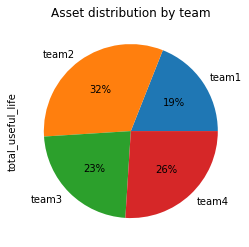

In [56]:
assets2.groupby('team')['total_useful_life'].count().plot(kind='pie', autopct='%1.f%%')
plt.title('Asset distribution by team')

In [57]:
events3 = pd.merge(events2, assets2, how='inner', on=['asset_id'])

Text(0, 0.5, '')

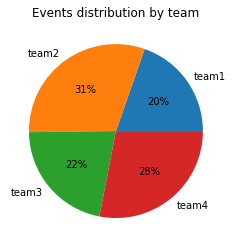

In [58]:
events3.groupby('team')['event_id'].count().plot(kind='pie', autopct='%1.f%%')
plt.title('Events distribution by team')
plt.ylabel('')

Text(0, 0.5, '%')

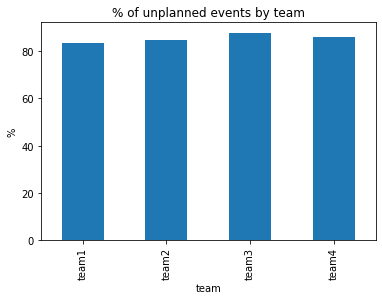

In [59]:
(events3.groupby('team')['planned_False'].sum() / events3.groupby('team')['planned_False'].count() * 100).plot(kind='bar')
plt.title('% of unplanned events by team')
plt.ylabel('%')

Text(0.5, 0, 'team')

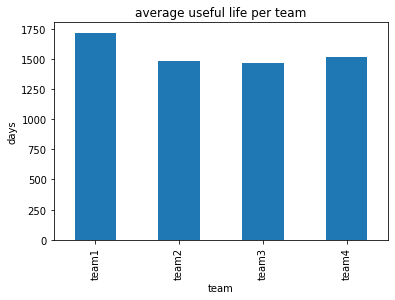

In [60]:
assets.groupby('asset_install_team')['total_useful_life'].mean().plot(kind='bar')
plt.title('average useful life per team')
plt.ylabel('days')
plt.xlabel('team')

Text(0.5, 0, 'team')

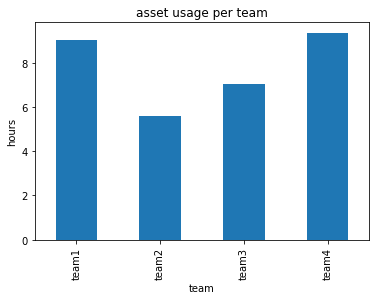

In [61]:
assets.groupby('asset_install_team')['asset_trains_per_hour'].mean().plot(kind='bar')
plt.title('asset usage per team')
plt.ylabel('hours')
plt.xlabel('team')

### 2.3.5. Asset usage and event occurence

In [62]:
(events3['event_date'].iloc[0] - events3['installed_date'].iloc[0]).days * 24 * events3['asset_trains_per_hour'].iloc[0]

3120.0

In [63]:
events3['trains_since_installed'] = (events3['event_date'] - events3['installed_date']).map(lambda x: x.days) * 24 * events3['asset_trains_per_hour']

In [64]:
events3.corr()['type_repair']

previous_repairs                0.794610
previous_unplanned              0.657852
type_repair                     1.000000
type_replacement               -1.000000
planned_False                  -0.164941
                                  ...   
total_unplanned_repairs         0.126666
total_unplanned_replacements   -0.049382
average_time_between_events    -0.014699
std_time_between_events        -0.014505
trains_since_installed         -0.010169
Name: type_repair, Length: 79, dtype: float64

<AxesSubplot:>

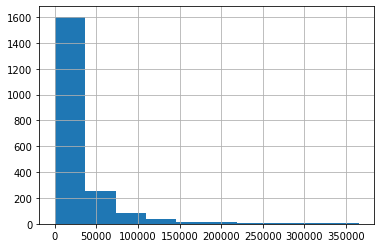

In [65]:
events3['trains_since_installed'].hist()

<AxesSubplot:>

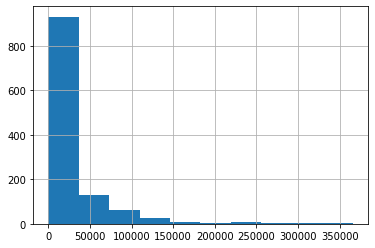

In [66]:
events3[events3['type_replacement'] == 1]['trains_since_installed'].hist()

<AxesSubplot:>

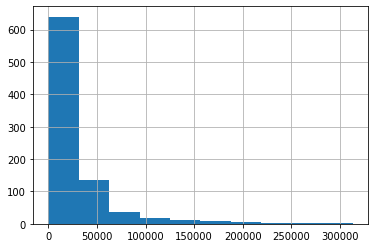

In [67]:
events3[events3['type_replacement'] == 0]['trains_since_installed'].hist()

<AxesSubplot:>

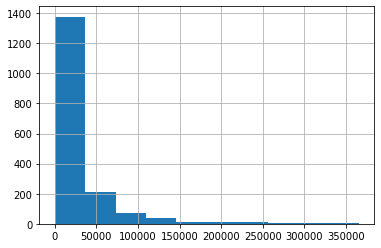

In [68]:
events3[events3['planned_False'] == 1]['trains_since_installed'].hist()

<AxesSubplot:>

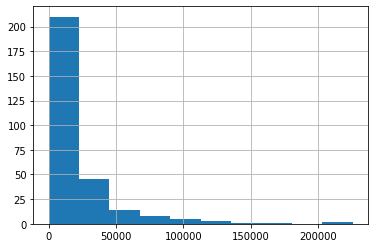

In [69]:
events3[events3['planned_False'] == 0]['trains_since_installed'].hist()

# 3. Predictive maintenance pipeline

The main goal with the predictive model is to reduce the number of unplanned events, since those drastically increase cost, downtime and liability.
Since most ot the events are unplanned ($85\%$), we have a **class imbalance**.
We'll make an assumption that will allow the simplification of the model.

**Assumptions**
- Models must predict occurence of events, the technical team will inspect the asset and determine one of three alternatives:
  - false positive (in time, the feedback data can be used to modify and further train the model)
  - repair necessary
  - replacement necessary


**Strategy**
There are several ways we can approach the problem:
- We can have different models, one for each time horizon and they'll be binary class models, since it's usually easier to get higher results with a binary classification. `explored`
- We can have a multi class model, where each time horizon is a different class. `not explored`
- We can cluster the assets based on the data we have and then run a model for different time horizons for each cluster. `not explored`
- We can try to predict the RUL for an asset, given its history and/or cluster properties. `aproached, not implemented`

**Plan**
- Augment events dataset
  - with "static" data from assets table
  - to indicate number of planned repair events in last 30/90/180/360/ever days
  - to indicate number of unplanned repair events in last 30/90/180/360/ever days
  - to indicate number of planned replacement events in last 30/90/180/360/ever days
  - to indicate number of unplanned replacement events in last 30/90/180/360/ever days
  - multiply usage per hour by the total number of hours
  - current life (event_date - start_date)
  - difference between average useful life and current life (average useful life - current_life)
    - average useful life must be updated when more data is collected
    - upgrade to use average useful life for events that match the features of the event being trained/inferred (e.g. weather, usage, team, material etc.)
- Add columns for indicating whether another event will happen in different time horizons: 30, 90, 180, 360 days - this is the target variable

## 3.1. Prepare dataset

As it is, the dataset is not ideal for creating a model.
There are not many variables with high correlation.
Moreover, we only have data for when the event already occurred, that is 

The dataset can be extended to include entries with dates between consequent events.
For example, consider that an event occurred in the 1st of march and then again in the 1st of may.
We can create 30 data points covering the month of january, with the indication that no event will happen in the next 30 days, but an event will happen in the next 90 days.
We can also create 30 data points for the month of february, with the indication that an event will happen in the next 30 days.

With this strategy, we'll be able to build a dataset that will contain a lot more rows than the events table.
To be specific, since the average useful life is 1530 days and we have 200 assets, we'll be able to build a dataset in the order of 300 000 rows.



In [70]:
events3['time_since_last_event'].describe()

count                           2032
mean     135 days 18:32:35.905511812
std      148 days 13:41:11.589129060
min                  0 days 00:00:00
25%                 37 days 00:00:00
50%                 90 days 00:00:00
75%                181 days 06:00:00
max               1385 days 00:00:00
Name: time_since_last_event, dtype: object

Features:
 - days since start_date - this will be a proxy for date (must be derived for each date for each date)
 - days since last installed date (must be derived for each date for each date)
 - trains since last installed date (must be derived for each date for each date)
 - trains since last event date (for each date for each date)
 - previous repairs since last replacement (original data)
 - previous unplanned repairs since last replacement (original data)
 - number of previous un/planned replacements (must be derived for each date for each date)
 - number of previous un/planned repairs (must be derived for each date)

Target
 - event in next 30 days (must be derived)
 - event in next 90 days (must be derived)
 - event in next 180 days (must be derived)
 - event in next 360 days (must be derived) (this might not make sense, since 75% of events happen within less than 181 days of each other)
 

### 3.1.1. Dataset creation

In [71]:
def event_in_X_time(date: pd.Timestamp,
                    asset_data: pd.DataFrame,
                    horizon: pd.Timedelta = pd.Timedelta(days=30)
                   ) -> bool:
    return (asset_data['event_date'] < (date + horizon)).sum() > 0

def get_last_event(date: pd.Timestamp,
                   asset_data: pd.DataFrame) -> pd.Series:
    prev_events = asset_data[asset_data['event_date'] < date]
    if prev_events.shape[0] == 0:
        return None
    else:
        return prev_events.iloc[-1]
    
    
EventCounts = namedtuple('EventCounts', ['planned_repairs', 'unplanned_repairs', 'planned_replacements', 'unplanned_replacements'])
def get_past_events_count(date: pd.Timestamp,
                          asset_data: pd.DataFrame) -> EventCounts:
    prev_events = asset_data[asset_data['event_date'] < date]
    planned_repairs = (prev_events['type_repair'] * prev_events['planned_True']).sum()
    unplanned_repairs = (prev_events['type_repair'] * prev_events['planned_False']).sum()
    planned_replacements = (prev_events['type_replacement'] * prev_events['planned_True']).sum()
    unplanned_replacements = (prev_events['type_replacement'] * prev_events['planned_False']).sum()

    return EventCounts(planned_repairs=planned_repairs,
                       unplanned_repairs=unplanned_repairs,
                       planned_replacements=planned_replacements,
                       unplanned_replacements=unplanned_replacements
                      )
    
def build_dataset(asset_data: pd.DataFrame,
                  horizons: List[int] = [30, 60, 180],
                  static_columns: List[str] = [],
                  start_date: Optional[pd.Timestamp] = None,
                  end_date: Optional[pd.Timestamp] = None) -> pd.DataFrame:
    df = pd.DataFrame()
    
    # static_data
    asset_start_date = asset_data.iloc[0]['start_date']
    trains_per_hour = asset_data.iloc[0]['asset_trains_per_hour']
    
    # create date range
    first_day = asset_start_date if start_date is None else start_date
    last_day = asset_data.iloc[-1]['event_date'] if end_date is None else end_date
    df['date'] = pd.date_range(start=first_day,
                               end=last_day)
    
    df['asset_id'] = asset_data.iloc[0]['asset_id']
    
    ## loop dates instead of using map for performance
    ## (not enough data to justify efficient parallelization)
    
    # create columns
    df['days_since_asset_start'] = 0
    df['days_since_last_event'] = 0
    
    df['repairs_since_replacement'] = 0
    df['unplanned_repairs_since_replacement'] = 0
    
    df['unplanned_repairs'] = 0
    df['planned_repairs'] = 0
    df['unplanned_replacements'] = 0
    df['planned_replacements'] = 0
    
    
    for horizon_days in horizons:
        df[f'horizon_{horizon_days}'] = 0
        
    for i, d in df['date'].items():
        # print(d)
        last_event = get_last_event(d, asset_data)
        
        # days since asset start date
        df.at[i, 'days_since_asset_start'] = (d - asset_start_date).days

        # days since last event
        df.at[i, 'days_since_last_event'] = (d - last_event['event_date']).days if last_event is not None else 0
     
        # previous repairs since last replacement
        df.at[i, 'repairs_since_replacement'] = last_event['previous_repairs'] if last_event is not None else 0
    
        # previous unplanned repairs since last replacement
        df.at[i, 'unplanned_repairs_since_replacement'] = last_event['previous_unplanned'] if last_event is not None else 0
        
        
        event_counts = get_past_events_count(d, asset_data)
        # total previous unplanned repairs
        df.at[i, 'unplanned_repairs'] = event_counts.unplanned_repairs
        
        # total previous planned repairs
        df.at[i, 'planned_repairs'] = event_counts.planned_repairs
        
        # total previous unplanned replacements
        df.at[i, 'unplanned_replacements'] = event_counts.unplanned_replacements
        
        # total previous planned replacements
        df.at[i, 'planned_replacements'] = event_counts.planned_replacements
        
        # check existence of events in specified horizons (days)
        for horizon_days in horizons:
            df.at[i, f'horizon_{horizon_days}'] = event_in_X_time(d, asset_data,
                                                                    pd.Timedelta(days=horizon_days))
     
    # trains since last event
    df['trains_since_last_event'] = df['days_since_last_event'] * 24 * trains_per_hour

    # trains since asset start date
    df['trains_since_asset_start'] = df['days_since_asset_start'] * 24 * trains_per_hour

    # add data from static columns
    for col in static_columns:
        if col not in asset_data:
            raise ValueError(f'column {col} does not exist in asset data')
        df[col] = asset_data.iloc[0][col]
        
    return df

def get_asset_data(asset_id, events_data) -> pd.DataFrame:
    return events_data[events_data['asset_id'] == asset_id]

In [72]:
# dataset cration parameteres
params = {
    'horizons': [30, 60, 90, 180, 360],
    'static_columns': []
}

#### 3.1.1.1. Create and store

In [ ]:
%%time
unique_ids = events['asset_id'].unique()

# first asset
asset_data = get_asset_data(unique_ids[0], events3)
df = build_dataset(asset_data, **params)

# remaing assets
for i, asset_id in enumerate(unique_ids[1:2]):
    print(i, asset_id, datetime.datetime.now())
    asset_data = get_asset_data(asset_id, events3)
    d = build_dataset(asset_data, **params)
    df = pd.concat([df, d], axis=0, ignore_index=True)

In [ ]:
static_df = assets[['asset_id', 'asset_install_team', 'asset_line', 'asset_material', 'asset_weather_cluster', 'end_date',]]

In [ ]:
df = pd.merge(df, static_df, on='asset_id')

In [ ]:
#remaining useful life
df['rul'] = (df['end_date'] - df['date']).map(lambda d: d.days)

In [ ]:
df.to_pickle(f'created_data_{datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")}.pkl')

#### 3.1.1.2. Load previous creation

In [73]:
df = pd.read_pickle('created_data_2022_05_04_00_05.pkl')
df

,date,asset_id,days_since_asset_start,days_since_last_event,repairs_since_replacement,unplanned_repairs_since_replacement,unplanned_repairs,planned_repairs,unplanned_replacements,planned_replacements,...,horizon_180,horizon_360,trains_since_last_event,trains_since_asset_start,asset_install_team,asset_line,asset_material,asset_weather_cluster,end_date,rul
0,2008-06-26,A:cpjwvv,0,0,0,0,0,0,0,0,...,True,True,0.0,0.0,team4,east_line,iron,standard,2012-02-26,1340
1,2008-06-27,A:cpjwvv,1,0,0,0,0,0,0,0,...,True,True,0.0,48.0,team4,east_line,iron,standard,2012-02-26,1339
2,2008-06-28,A:cpjwvv,2,0,0,0,0,0,0,0,...,True,True,0.0,96.0,team4,east_line,iron,standard,2012-02-26,1338
3,2008-06-29,A:cpjwvv,3,0,0,0,0,0,0,0,...,True,True,0.0,144.0,team4,east_line,iron,standard,2012-02-26,1337
4,2008-06-30,A:cpjwvv,4,0,0,0,0,0,0,0,...,True,True,0.0,192.0,team4,east_line,iron,standard,2012-02-26,1336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238405,2016-12-20,A:o56vf4,25,0,0,0,0,0,0,0,...,True,True,0.0,2400.0,team1,north_line,steel,snow,2017-05-10,141
238406,2016-12-21,A:o56vf4,26,0,0,0,0,0,0,0,...,True,True,0.0,2496.0,team1,north_line,steel,snow,2017-05-10,140
238407,2016-12-22,A:o56vf4,27,0,0,0,0,0,0,0,...,True,True,0.0,2592.0,team1,north_line,steel,snow,2017-05-10,139
238408,2016-12-23,A:o56vf4,28,0,0,0,0,0,0,0,...,True,True,0.0,2688.0,team1,north_line,steel,snow,2017-05-10,138


### 3.1.2. Pre-processing

In [74]:
# transform true and false to 1 and 0
for horizon in params['horizons']:
    df[f'horizon_{horizon}'] = df[f'horizon_{horizon}'].map(lambda x: 1 if x else 0)
    
    # measure class imbalance
    pct = df[f'horizon_{horizon}'].sum() / df.shape[0]
    print(f'class horizon {horizon}: {pct*100}% positive')

class horizon 30: 89.22947862925213% positive
class horizon 60: 90.97730799882555% positive
class horizon 90: 92.41810326748039% positive
class horizon 180: 95.55345832809027% positive
class horizon 360: 98.55207415796318% positive


In [75]:
df = pd.get_dummies(df, columns=['asset_install_team', 'asset_line', 'asset_weather_cluster'])

In [76]:
df

,date,asset_id,days_since_asset_start,days_since_last_event,repairs_since_replacement,unplanned_repairs_since_replacement,unplanned_repairs,planned_repairs,unplanned_replacements,planned_replacements,...,asset_install_team_team4,asset_line_east_line,asset_line_north_line,asset_line_south_line,asset_line_west_line,asset_weather_cluster_heavy_rain,asset_weather_cluster_rain,asset_weather_cluster_snow,asset_weather_cluster_standard,asset_weather_cluster_sun
0,2008-06-26,A:cpjwvv,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,1,0
1,2008-06-27,A:cpjwvv,1,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,1,0
2,2008-06-28,A:cpjwvv,2,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,1,0
3,2008-06-29,A:cpjwvv,3,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,1,0
4,2008-06-30,A:cpjwvv,4,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238405,2016-12-20,A:o56vf4,25,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
238406,2016-12-21,A:o56vf4,26,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
238407,2016-12-22,A:o56vf4,27,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
238408,2016-12-23,A:o56vf4,28,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0


<AxesSubplot:>

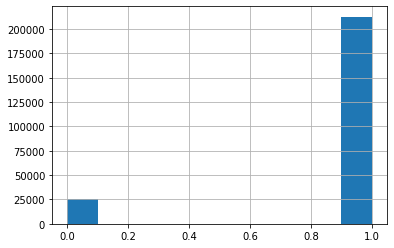

In [77]:
df['horizon_30'].hist()

We have a very large dataset to work with, but it is very imbalanced.
We can either modify the input distribution to make it balanced or use appropriate models and metrics that can handle this imbalance.

Since we have a rather large dataset, we'll proceed by removing enough samples from the dominant class to make the final dataset balanced (50/50 split between classes), and use the leftover set (which consists of only one class) as a validation set.

In [78]:
def binary_balanced_sample(x: pd.DataFrame, target: str, tolerance: float = 0.1) -> Tuple[pd.DataFrame, pd.DataFrame]:
    '''
    :param x: input dataset
    :type x: pandas.DataFrame
    :param target: column name of binary class
    :type target: str
    :returns: balanced dataset, 
    '''
    unique_values = x[target].unique()
    if unique_values.size != 2:
        raise TypeError(f'{target} has {unique_values.size} classes, not 2')
    
    idx = [x[x[target] == c].index for c in unique_values]
    small_class_idx, big_class_idx = sorted(idx, key=lambda k: k.size)
    
    # check if already balanced
    
    # balance by sampling from the big class the number of rows in the small class
    big_sampled = x.iloc[big_class_idx].sample(small_class_idx.size)
    x_balanced = pd.concat([big_sampled, x.iloc[small_class_idx]])
    left_out = x.iloc[x.index.difference(x_balanced.index)]
    
    return x_balanced, left_out

In [79]:
horizon = 30

In [80]:
df_balanced, left_out = binary_balanced_sample(df, f'horizon_{horizon}')

In [81]:
df_balanced.shape

(51356, 33)

<AxesSubplot:>

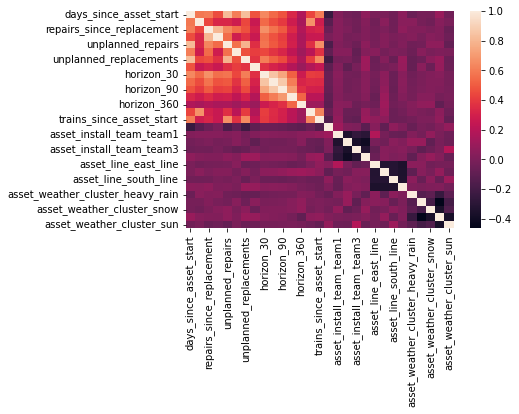

In [82]:
sns.heatmap(df_balanced.corr())

In [83]:
df_balanced.corr()[f'horizon_{horizon}'].sort_values()

rul                                   -0.067444
asset_line_south_line                 -0.060438
asset_weather_cluster_heavy_rain      -0.043336
asset_install_team_team3              -0.035538
asset_install_team_team2              -0.031875
asset_line_east_line                  -0.023435
asset_weather_cluster_sun             -0.021373
asset_weather_cluster_rain            -0.007729
asset_weather_cluster_snow             0.014974
asset_install_team_team4               0.031330
asset_weather_cluster_standard         0.032552
asset_line_west_line                   0.035154
asset_install_team_team1               0.039616
asset_line_north_line                  0.046963
horizon_360                            0.268441
planned_replacements                   0.364269
trains_since_asset_start               0.396120
trains_since_last_event                0.408523
planned_repairs                        0.439423
horizon_180                            0.510015
days_since_last_event                  0

For the balanced datasets, we have.

| horizon | size | columns with correlation > 0.2, descending order |
| ------- | ----- | -- |
| 30 | 51356 | repairs_since_replacement |
| | |days_since_asset_start|
| | |unplanned_replacements|
| | |unplanned_repairs|
| | |unplanned_repairs_since_replacement|
| | | days_since_last_event|
| | | planned_repairs |
| | | trains_since_last_event |
| | | trains_since_asset_start |
| | | planned_replacements |
| 60 | 43022 | same | 
| 90 | 36152 | same |
| 180 | 21202 | same |
| 360 | 6904| same + asset_line_north_line (least correlated)|

The Remaining Useful Life columns should not be considered here for classification training, since it's relevant for the regression model.

We can see that for most horizons, the static variables (weather, line, team, material) don't really matter.
In general, but specially for algorithms that don't handle a large number of variables, we can drop these safely.
Furthermore, there are variables that are highly correlated, e.g.
- trains_since_last_event is derived from days_since_last_event;
- trains_since_asset_start is derived from days_since_asset_start;
- un/planned repairs and un/planned replacements are counters since the the start_date of the asset, so they are also correlated, even though they don't directly cause each other.

We won't perform **dimensionalty reduction** (such as PCA).
For algorithms that do well with many variables, we'll simply not use low correlation variables.

2. **which features?**
3. **k-folds?**
4. **which model?**
5. **grid/random search?**




### 3.1.3. Data split and feature selection

In [84]:
# choose input dataset (imbalanced)
dfX = df.copy()
print(dfX.shape)

(238410, 33)


Since we have a decently sized dataset, a simple train/validation split should suffice to get decent results, i.e. k-fold is not necessary.

In [85]:
dfX.columns

Index(['date', 'asset_id', 'days_since_asset_start', 'days_since_last_event',
       'repairs_since_replacement', 'unplanned_repairs_since_replacement',
       'unplanned_repairs', 'planned_repairs', 'unplanned_replacements',
       'planned_replacements', 'horizon_30', 'horizon_60', 'horizon_90',
       'horizon_180', 'horizon_360', 'trains_since_last_event',
       'trains_since_asset_start', 'asset_material', 'end_date', 'rul',
       'asset_install_team_team1', 'asset_install_team_team2',
       'asset_install_team_team3', 'asset_install_team_team4',
       'asset_line_east_line', 'asset_line_north_line',
       'asset_line_south_line', 'asset_line_west_line',
       'asset_weather_cluster_heavy_rain', 'asset_weather_cluster_rain',
       'asset_weather_cluster_snow', 'asset_weather_cluster_standard',
       'asset_weather_cluster_sun'],
      dtype='object')

In [86]:
columns_target = ['horizon_30', 'horizon_60', 'horizon_90', 'horizon_180', 'horizon_360']

PrepSet = namedtuple('PrepData', ['X', 'y'])
PrepData = namedtuple('AllData', ['train', 'test', 'val'])
def getXy(data: pd.DataFrame, train_cols: List[str], target: str) -> PrepSet:
    return PrepSet(X=data[train_cols], y=data[target])


In [87]:
def getTrainTestVal(data: pd.DataFrame, cols: List[str], target: str, test_size: float = 0.2) -> PrepData:
    # balance chosen dataset according to specified target column
    df_balanced, left_out = binary_balanced_sample(data, target)

    # split into "inference" set and target set
    train_test = getXy(df_balanced, cols, target)

    # split left out set into validation inference/target sets
    val = getXy(left_out, cols, target)

    # train/test split
    Xtrain, Xtest, ytrain, ytest = train_test_split(train_test.X, train_test.y, test_size=test_size)
    
    train = PrepSet(X=Xtrain, y=ytrain)
    test = PrepSet(X=Xtest, y=ytest)
    
    ret = PrepData(
        train=train,
        test=test,
        val=val
    )
    return ret

## 3.2. Single Class Multi Model

In [88]:
def compute_metrics(ytrue: np.array, ypred: np.array) -> dict:
    acc = metrics.accuracy_score(ytrue, ypred)
    recall = metrics.recall_score(ytrue, ypred)
    cm = confusion_matrix(ytrue, ypred)
    cm2 =  {'tn': cm[0, 0], 'fp': cm[0, 1],
           'fn': cm[1, 0], 'tp': cm[1, 1]}
    precision = cm2['tp'] / (cm2['tp'] + cm2['fp'])
    return {'accuracy': acc, 'recall': recall, 'confusion': cm, 'precision': precision}

def compute_metrics_scorer(clf, X, ytrue: np.array) -> dict:
    ypred = clf.predict(X)
    acc = metrics.accuracy_score(ytrue, ypred)
    recall = metrics.recall_score(ytrue, ypred)
    cm = confusion_matrix(ytrue, ypred)
    cm =  {'tn': cm[0, 0], 'fp': cm[0, 1],
           'fn': cm[1, 0], 'tp': cm[1, 1]}
    precision = cm['tp'] / (cm['tp'] + cm['fp'])
    return {'accuracy': acc, 'recall': recall, 'precision': precision}

In [89]:
def test_model(data, clf, model_meta: dict) -> PrepData:
    prep_data = getTrainTestVal(dfX, model_meta['columns'], model_meta['target'])
    print(f'\n\nTarget variable = {model_meta["target"]}')
    with mlflow.start_run(run_name=f"{model_meta['type']}_{model_meta['target']}"):

        # setup and train model
        clf.fit(prep_data.train.X, prep_data.train.y)

        # make predictions for train, test, val
        ytrain_pred = clf.predict(prep_data.train.X)
        ytest_pred = clf.predict(prep_data.test.X)
        yval_pred = clf.predict(prep_data.val.X)

        # compute metrics for train, test and val
        run_metrics = {}
        run_metrics['train'] = compute_metrics(prep_data.train.y, ytrain_pred)
        run_metrics['test'] = compute_metrics(prep_data.test.y, ytest_pred)
        run_metrics['val'] = compute_metrics(prep_data.val.y, yval_pred)

        # log datasets size
        mlflow.log_param('target', model_meta['target'])
        mlflow.log_param('n_features', prep_data.train.X.shape[1])
        mlflow.log_param('train_size', prep_data.train.X.shape[0])
        mlflow.log_param('test_size', prep_data.test.X.shape[0])
        mlflow.log_param('val_size', prep_data.val.X.shape[0])

        # log params
        for param, val in model_meta['params'].items():   
            mlflow.log_param(param, val)

        # log metrics
        for s in ['train', 'test', 'val']:
            for m in ['accuracy', 'recall', 'precision']:
                print(f"{s}_{m} - {run_metrics[s][m]}")
                mlflow.log_metric(f"{s}_{m}", run_metrics[s][m])
        
        # plot confusion matrix for test and val sets
        ConfusionMatrixDisplay(run_metrics['test']['confusion']).plot()
        plt.title('Confusion matrix for test set' + f' | {model_meta["target"]}')
        figCT = plt.gcf()

        ConfusionMatrixDisplay(run_metrics['val']['confusion']).plot()
        plt.title('Confusion matrix for validation set' + f' | {model_meta["target"]}')
        figCV = plt.gcf()

        # plot feature importance
        if hasattr(clf, "feature_importances_"):
            figFI = plt.figure()
            plt.barh(list(prep_data.train.X.columns), clf.feature_importances_)
            plt.title('Feature importance' + f' | {model_meta["target"]}')
            plt.xlabel('Gini importance')
            plt.ylabel('Feature')
            plt.tight_layout()
            mlflow.log_figure(figFI, "feature_importance.png")

        if isinstance(clf, DecisionTreeClassifier):
            figDP = plt.figure()
            plt.title('Decision path' + f' | {model_meta["target"]}')
            tree.plot_tree(clf)
            mlflow.log_figure(figDP, "decision_path.png")

        # log figures
        mlflow.log_figure(figCT, "test_confusion.png")
        mlflow.log_figure(figCV, "val_confusion.png")
        



        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

        # Model registry does not work with file store
        if tracking_url_type_store != "file":
            mlflow.sklearn.log_model(clf, "model", registered_model_name="DecisionTree_" + model_meta['target'])
        else:
            mlflow.sklearn.log_model(clf, "model")

### 3.2.1 First approach - Decision Tree



Target variable = horizon_30
train_accuracy - 0.9878298120922987
train_recall - 0.9756513270026783
train_precision - 1.0
test_accuracy - 0.9888045171339563
test_recall - 0.9776395100136107
test_precision - 1.0
val_accuracy - 0.9761245415762293
val_recall - 0.9761245415762293
val_precision - 1.0


Target variable = horizon_60
train_accuracy - 0.9790510503530232
train_recall - 0.9579493759477429
train_precision - 1.0
test_accuracy - 0.9766414875072632
test_recall - 0.9539518900343643
test_precision - 1.0
val_accuracy - 0.9577916760497063
val_recall - 0.9577916760497063
val_precision - 1.0


Target variable = horizon_90
train_accuracy - 0.9705750146952041
train_recall - 0.9411031905322168
train_precision - 1.0
test_accuracy - 0.9723413082561195
test_recall - 0.9448580093741384
test_precision - 1.0
val_accuracy - 0.9433990250076635
val_recall - 0.9433990250076635
val_precision - 1.0


Target variable = horizon_180
train_accuracy - 0.9569011261128472
train_recall - 0.9140707652521453
trai

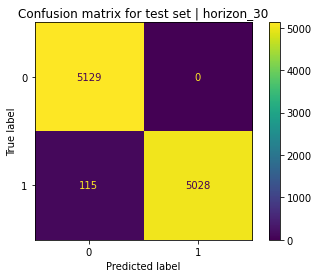

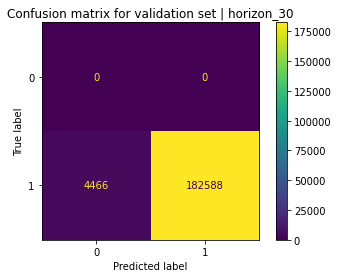

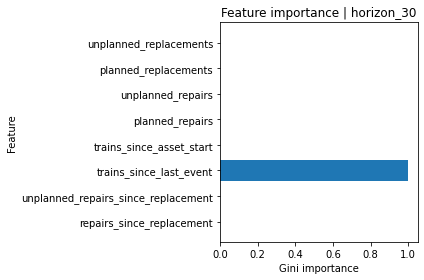

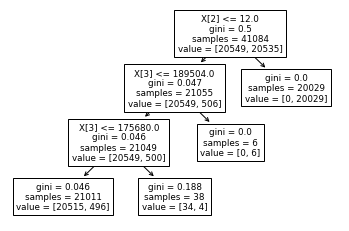

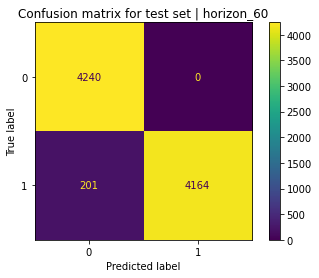

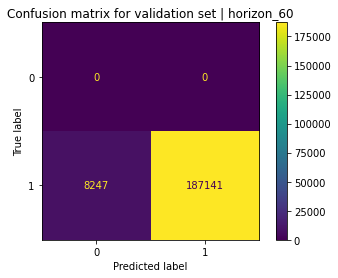

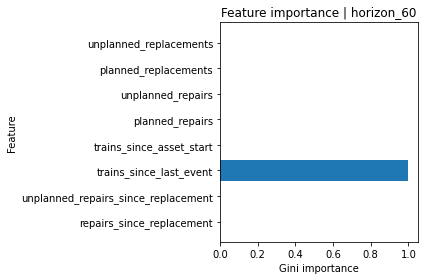

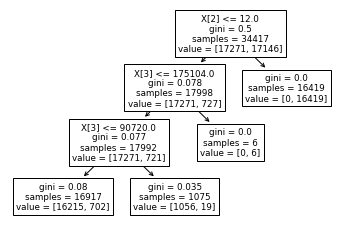

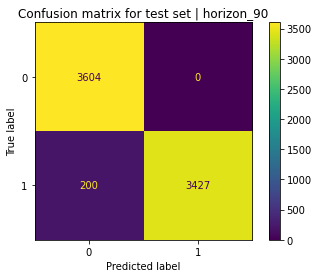

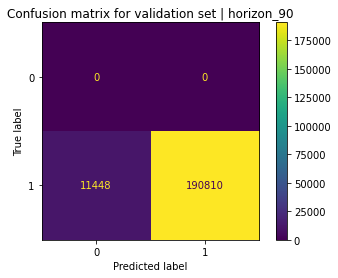

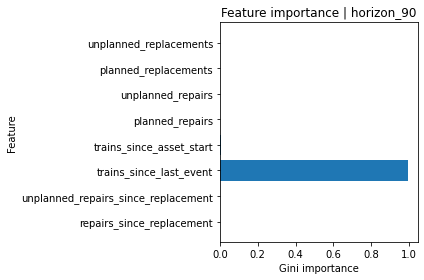

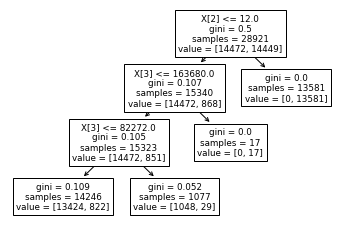

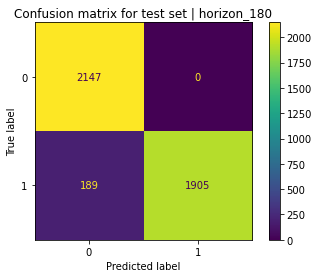

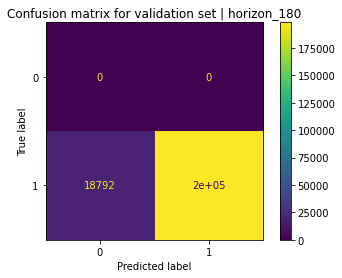

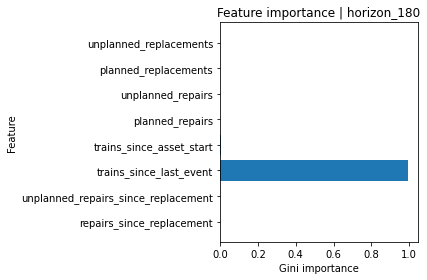

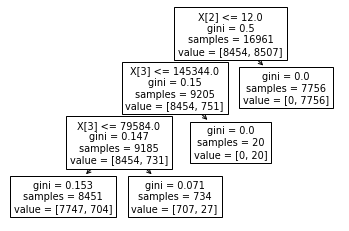

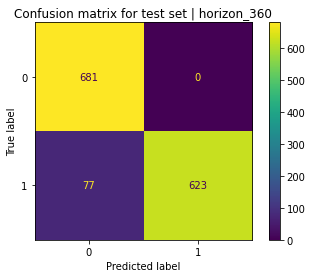

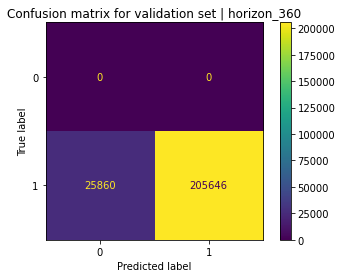

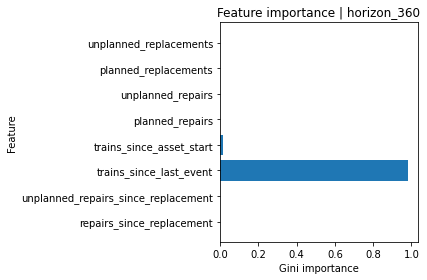

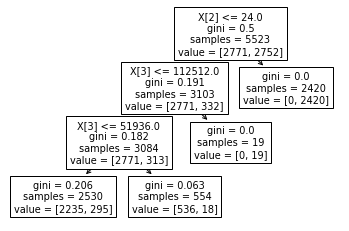

In [90]:
for target_c in columns_target:
    model_meta = {
        'target': target_c,
        'columns':
            [
                #'days_since_asset_start',
                #'days_since_last_event',  # excluded because it leads to trains_since_start
                'repairs_since_replacement',
                'unplanned_repairs_since_replacement',
                'trains_since_last_event',
                'trains_since_asset_start',
                'planned_repairs',
                'unplanned_repairs',
                'planned_replacements',
                'unplanned_replacements'
            ],
        'type': 'DecisionTreeClassifier',
        'params': {
            'max_depth': 3,
            'criterion': 'gini'
        }
    }

    prep_data = getTrainTestVal(dfX, model_meta['columns'], model_meta['target'])
    clf = DecisionTreeClassifier(**model_meta['params'])
    test_model(prep_data, clf, model_meta)

In [91]:
print(f'{138/(138+5089)*100:.2f} % test false negative ')
print(f'{4430/(4430+182624)*100:.2f} % validation false negative ')

2.64 % test false negative 
2.37 % validation false negative 


### 3.2.2. Discussion of first results

From a first simple model for the 30 day horizon, we already got a very high accuracy and recall.
The most important feature is, by far, trains_since_last_event.
One interesting result is that we have very few false positives, compared to false negatives.
This means that the model rarely predicts the existence of an event where, in fact, none actually existed.
In other words, the model is exhibiting a optimist behaviour, i.e. "when in doubt, predict there will not be an event".

| horizon | accuracy (train) | recall (train) | precision (train) |
| - | - | -| - |
| 30 |  98.79% | 97.59%  | 100% |
| 60 | 97.92% | 91.44% | 100% |
| 90 | 97.15% | 94.28% | 100% |
| 180 | 95.70% | 91.44% | 100% |
| 360 | 94.29% | 88.60% | 100% |

(Note: values of the above table might differ slightly from the cell output above, because of difference between runs.)

All models perform relatively well.
Models for shorter horizons perform better.
This means that the models that predict for more recent events are more trustworthy.
Still, models that predict for a longer time frame still perform well and can inform decisions for resource management in the future.

### 3.2.3. **Tuning models and business impact**

This result requires some discussion regarding **business impact**.
Intervention for an unplanned event incurrs a much higher mobilization of resources (time, costs, people, downtime, etc.) than for a planned event.
But if our model starts to predict a lot of false positives, that will flood the maintenance teams with requests, which means we need to expand the maintenance team, which will also increase the necessary resources.

We want our system to walk the fine line between
- reducing the amount of unplanned events, and
- avoid overestimating the number of planned events.

Currently, of all dates where an event would occur within the specified time horizon, 2% were not predicted, i.e. 98% recall.
Those 2% would result in unplanned events.
The original distribution has 85% of unplanned events.
According to our assumption, when an event is predicted within a time frame, the team can be deployed and analyze the asset closely, determining if a repair or replacement is necessary, and making a planned intervention before an unplanned event has a chance to occur.

### 3.2.4. Grid search for best decision tree

In [92]:
model_meta = {
    'target': columns_target[0],
    'columns':
        [
            'days_since_asset_start',
            #'days_since_last_event',  # excluded because it leads to trains_since_start
            'repairs_since_replacement',
            'unplanned_repairs_since_replacement',
            'trains_since_last_event',
            'trains_since_asset_start',
            'planned_repairs',
            'unplanned_repairs',
            'planned_replacements',
            'unplanned_replacements'
        ],
    'type': 'DecisionTreeClassifier_best',
    'params': {
        'max_depth': [1,2,3,4,5,6,7,8,9,10, None],
        'criterion': ['entropy', 'gini'],
        'splitter' : ['best', 'random'],
    }
}

prep_data = getTrainTestVal(dfX, model_meta['columns'], model_meta['target'])


In [228]:
gsc = GridSearchCV(DecisionTreeClassifier(),
                   param_grid=model_meta['params'],
                   scoring=compute_metrics_scorer,
                   return_train_score=True,
                   refit='recall')

In [229]:
gsc.fit(prep_data.train.X, prep_data.train.y)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None],
                         'splitter': ['best', 'random']},
             refit='recall', return_train_score=True,
             scoring=<function compute_metrics_scorer at 0x7f02958d5dc0>)

In [260]:
gsc.best_estimator_.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}



Target variable = horizon_30
train_accuracy - 0.9870265796903904
train_recall - 0.974163469476956
train_precision - 0.999950149551346
test_accuracy - 0.9875389408099688
test_recall - 0.9771967760959308
test_precision - 0.9975918121613486
val_accuracy - 0.9770119858436601
val_recall - 0.9770119858436601
val_precision - 1.0


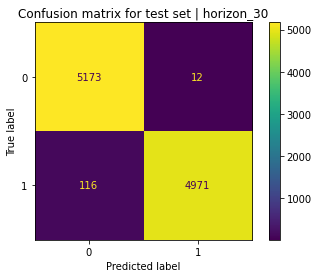

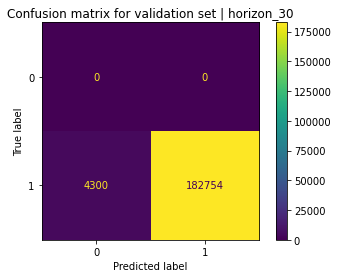

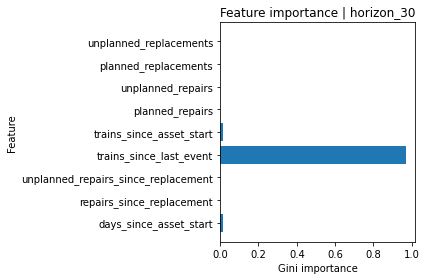

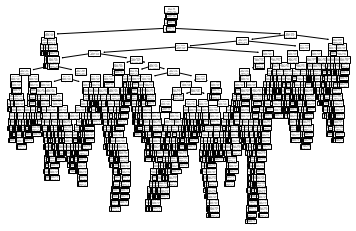

In [263]:
test_model(prep_data, gsc.best_estimator_, model_meta)

The best decision tree, with the added complexity, barely differs from the simpler, first try, model we trained.

**The added complexity, in this case, is not worth it.**
The decision tree from the first model is easily explainable.
The best model has a very deep tree, hard to explain.

It's also interesting to see how the feature importance plot remains mostly the same too, but with 2 new variables now making a very small contribution.

After training several models and performing a grid search, let's finally look at the test and validation metrics.
They're all very good too.
Precision in the test set is lower, since we finally have some false positives.
The validation set only has positives, and we got around 98% correct.

### 3.2.5. Ensemble method - Random Forest



Target variable = horizon_30
train_accuracy - 0.9888034271249148
train_recall - 0.977640596898848
train_precision - 1.0
test_accuracy - 0.9879283489096573
test_recall - 0.9757100881488736
test_precision - 1.0
val_accuracy - 0.9762581928213243
val_recall - 0.9762581928213243
val_precision - 1.0


Target variable = horizon_60
train_accuracy - 0.9794287706656594
train_recall - 0.9588396023487007
train_precision - 1.0
test_accuracy - 0.9778036025566531
test_recall - 0.9556844547563805
test_precision - 1.0
val_accuracy - 0.9581192294306713
val_recall - 0.9581192294306713
val_precision - 1.0


Target variable = horizon_90
train_accuracy - 0.9727533626084852
train_recall - 0.9454180231350003
train_precision - 1.0
test_accuracy - 0.9705434932927672
test_recall - 0.9414674361088211
test_precision - 1.0
val_accuracy - 0.9436165689367046
val_recall - 0.9436165689367046
val_precision - 1.0


Target variable = horizon_180
train_accuracy - 0.9596721891397912
train_recall - 0.9194061505832449
train

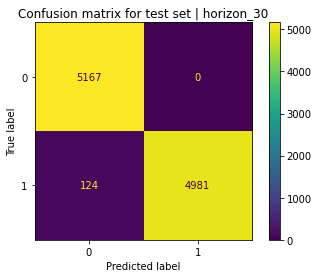

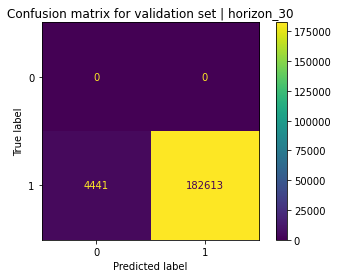

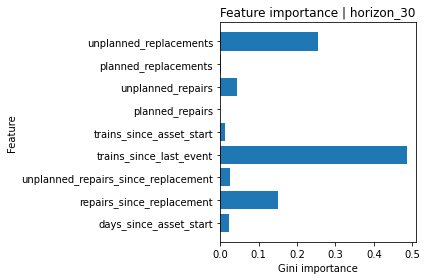

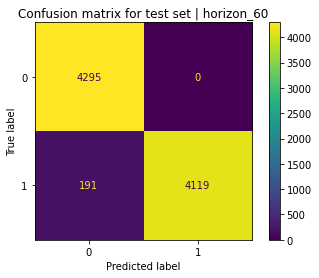

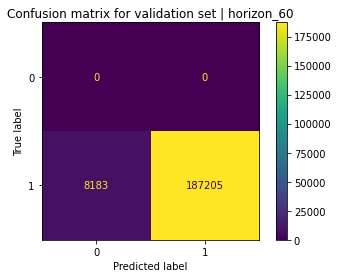

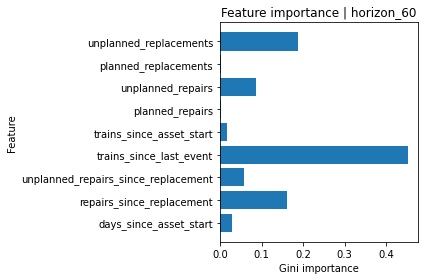

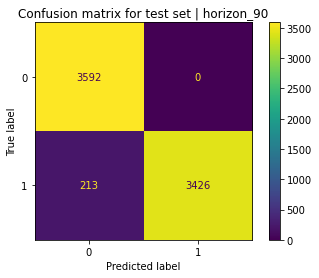

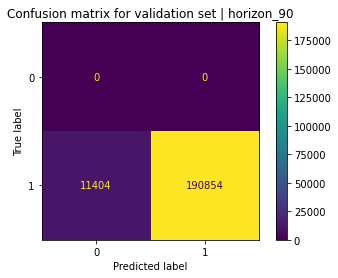

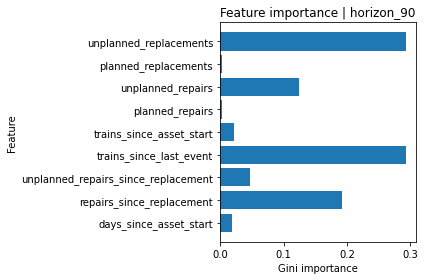

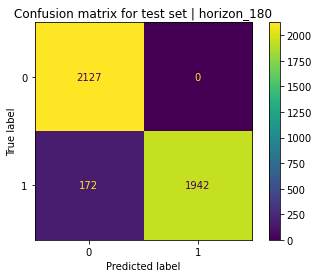

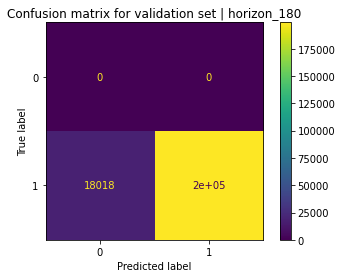

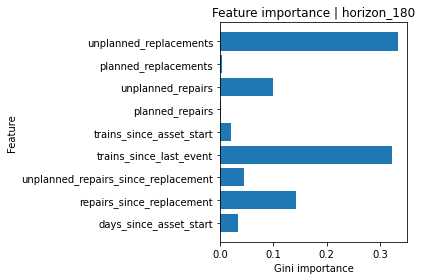

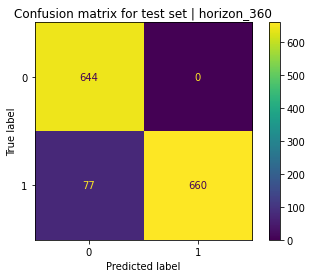

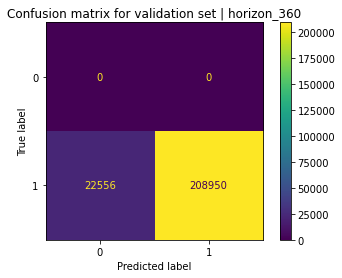

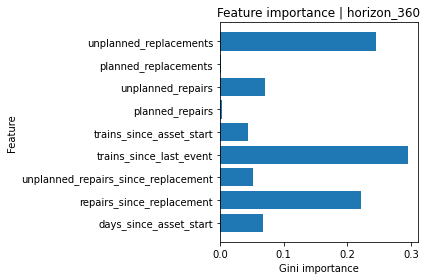

In [264]:
for target_c in columns_target:
    model_meta = {
        'target': target_c,
        'columns':
            [
                'days_since_asset_start',
                #'days_since_last_event',  # excluded because it leads to trains_since_start
                'repairs_since_replacement',
                'unplanned_repairs_since_replacement',
                'trains_since_last_event',
                'trains_since_asset_start',
                'planned_repairs',
                'unplanned_repairs',
                'planned_replacements',
                'unplanned_replacements'
            ],
        'type': 'RandomForestClassifier',
        'params': {
            'max_depth': 10,
            'n_estimators': 50,
            'criterion': 'entropy'  # was best criterion during grid search
        }
    }

    prep_data = getTrainTestVal(dfX, model_meta['columns'], model_meta['target'])
    clf = RandomForestClassifier(**model_meta['params'])
    test_model(dfX, clf, model_meta)

For all its added complexity, the Random Forest Classifier did not significantly outperform the simpler decision trees.
In fact, the difference is marginal.
Because of the added complexity and reduced explainability, the final choice falls onto the decision trees.

### 3.2.6. Other models

SVMs were considered, but they're not well suited for large datasets, specially because of the memory footprint.

Given how well simple decision trees performed, many models will likely also perform very well.
The question is whether the added complexity is worth it for the simple features describing the data.

When we deploy this system into production, we'll be able to collect other features, namely, false positives from the inspection of the maintenance teams.

With more features, more complexity might be required to tune the system.
For now, having a simple model will make it easier to deploy and maintain.

### 3.2.7. How to use this approach?

Each model should run every day for all assets and for a specific asset whenever an event occurs, since that alters the input parameters for the prediction.
For example, if an asset had a prediction for the next 60 days but not the next 30, the management team might not have allocated people to look into this asset.
If that asset failed unexpectedly, then maybe the model will predict no events for the next 90 days, since the parameters changed.

For each asset, the input features must be updated, namely, e.g. trains_since_last_event, trains_since_start_date, planned_repairs, unplanned_repalcements, etc.

With the results we currently have, we should use very simple decision trees.

## 3.3. Predict Remaining Useful Life (RUL) (Regression)

The Remaining Useful Life is the amount of time left until the retirement of an asset.

**Assumption: the retirement of an asset is the end_date in the assets table.**

At any given day, the retirement of an asset is that day subtracted from the end date.

In the first models, we tried to predict whether a maintenance event would occur withing a given time frame.
Here, we'll try to predict the RUL of a given asset, given what we know about it know.
Some of this knowledge is static, e.g. material, line, weather cluster, team.
Other is derived, e.g. how many trains passed since the beginning, how many repairs, how many replacements.
These derived features have already been computed during the dataset creation, in section 3.1.1.

### 3.3.1. Visualize the data

Let's visualize the distribution of a few variables against our target variable.

In [93]:
dfX = df.copy()

In [103]:
dfX.corr()['rul'].sort_values()

days_since_asset_start                -0.347762
unplanned_replacements                -0.304429
unplanned_repairs                     -0.233292
trains_since_asset_start              -0.185330
days_since_last_event                 -0.151478
planned_replacements                  -0.127164
planned_repairs                       -0.106373
asset_weather_cluster_heavy_rain      -0.075234
asset_line_north_line                 -0.069816
trains_since_last_event               -0.066996
horizon_360                           -0.059791
horizon_180                           -0.056517
repairs_since_replacement             -0.053611
horizon_90                            -0.047199
horizon_60                            -0.042922
horizon_30                            -0.042383
asset_install_team_team4              -0.032942
asset_weather_cluster_snow            -0.030565
asset_install_team_team3              -0.024080
asset_weather_cluster_rain             0.003605
asset_line_east_line                   0

In [124]:
def getTrainTestVal_regressor(data: pd.DataFrame, cols: List[str], target: str, test_size: float = 0.2) -> PrepData:
    # split into "inference" set and target set
    train_test = getXy(data, cols, target)

    # train/test split
    Xtrain, Xtest, ytrain, ytest = train_test_split(train_test.X, train_test.y, test_size=test_size)
    
    train = PrepSet(X=Xtrain, y=ytrain)
    test = PrepSet(X=Xtest, y=ytest)
    
    ret = PrepData(
        train=train,
        test=test,
        val=None
    )
    return ret

In [99]:
dfX.columns

Index(['date', 'asset_id', 'days_since_asset_start', 'days_since_last_event',
       'repairs_since_replacement', 'unplanned_repairs_since_replacement',
       'unplanned_repairs', 'planned_repairs', 'unplanned_replacements',
       'planned_replacements', 'horizon_30', 'horizon_60', 'horizon_90',
       'horizon_180', 'horizon_360', 'trains_since_last_event',
       'trains_since_asset_start', 'asset_material', 'end_date', 'rul',
       'asset_install_team_team1', 'asset_install_team_team2',
       'asset_install_team_team3', 'asset_install_team_team4',
       'asset_line_east_line', 'asset_line_north_line',
       'asset_line_south_line', 'asset_line_west_line',
       'asset_weather_cluster_heavy_rain', 'asset_weather_cluster_rain',
       'asset_weather_cluster_snow', 'asset_weather_cluster_standard',
       'asset_weather_cluster_sun'],
      dtype='object')

In [137]:
x_col = 'days_since_asset_start'

xx = dfX[[x_col, 'rul']].sort_values(x_col)
x = xx[x_col].to_numpy()
y = xx['rul'].to_numpy()

Text(0.5, 1.0, 'RUL/days_since_asset_start')

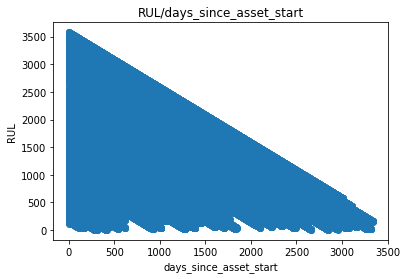

In [139]:
plt.scatter(x[::],y[::])
plt.ylabel('RUL')
plt.xlabel(x_col)
plt.title(f'RUL/{x_col}')

As we can see, the data is very non linear.

### 3.3.2. Linear regressor as baseline

In [166]:
with mlflow.start_run(run_name='linear regressor RUL', experiment_id=2):
    x = x.reshape(-1, 1)
    y = y.reshape(-1, 1)
    
    mlflow.log_param('input_cols', x_col)

    # let us train the model
    m = LinearRegression()
    m.fit(x, y)

    ŷ = m.predict(x)
    
    score = metrics.r2_score(y, ŷ)
    mae = metrics.mean_absolute_error(y, ŷ)
    mse = metrics.mean_squared_error(y, ŷ)
    
    mlflow.log_metric('score', score)
    mlflow.log_metric('mae', mae)
    mlflow.log_metric('mse', mse)
    
    print('score', score)
    print('mae', mae)
    print('mse', mse)
    

score 0.12093846066387592
mae 619.3212894878717
mse 556258.9322253341


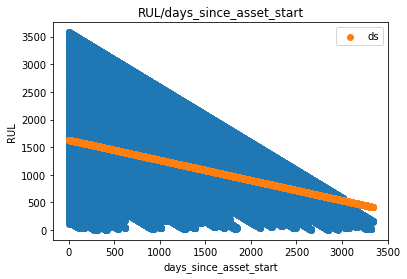

In [169]:
plt.scatter(x[::],y[::], label='true')
plt.scatter(x[::],ŷ[::], label='predicted')
plt.ylabel('RUL')
plt.xlabel(x_col)
plt.title(f'RUL/{x_col}')
plt.legend()

As expected, the linear regressor has very poor performance.

### 3.3.3. Random Forest Regressor

In [171]:
model_meta = {
    'target': 'rul',
    'columns':
        [
            'days_since_asset_start',
            'days_since_last_event',
            'repairs_since_replacement',
            'unplanned_repairs_since_replacement',
            'trains_since_last_event',
            'trains_since_asset_start',
            'planned_repairs',
            'unplanned_repairs',
            'planned_replacements',
            'unplanned_replacements'
        ],
    'type': 'RandomForestRegressor',
    'params': {
        'max_depth': 40,
        'n_estimators': 50,
        'criterion': "squared_error"
    }
}
prep_data = getTrainTestVal_regressor(dfX, model_meta['columns'], model_meta['target'])


In [172]:
%%time
with mlflow.start_run(run_name='random forest regressor RUL', experiment_id=2):
    mlflow.log_param('input_cols', str(list(prep_data.train.X.columns)))

    # let us train the model
    clf = RandomForestRegressor(**model_meta['params'])
    
    mlflow.log_param('criterion', clf.get_params()['criterion'])
    clf.fit(prep_data.train.X, prep_data.train.y)
    
    ŷ = clf.predict(prep_data.train.X)

    score = metrics.r2_score(prep_data.train.y, ŷ)
    mae = metrics.mean_absolute_error(prep_data.train.y, ŷ)
    mse = metrics.mean_squared_error(prep_data.train.y, ŷ)
    
    print('score', score)
    print('mae', mae)
    print('mse', mse)
    
    mlflow.log_metric('score', score)
    mlflow.log_metric('mae', mae)
    mlflow.log_metric('mse', mse)

score 0.849104957654269
mae 102.95276784040664
mse 95478.18990545053


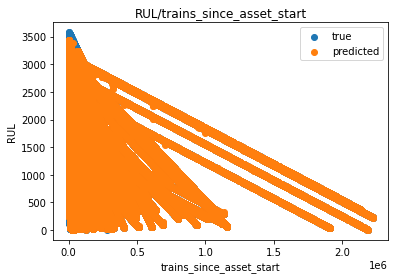

In [173]:
plt.scatter(prep_data.train.X['trains_since_asset_start'], prep_data.train.y, label='true')
plt.scatter(prep_data.train.X['trains_since_asset_start'], ŷ, label='predicted')

plt.ylabel('RUL')
plt.xlabel('trains_since_asset_start')
plt.title(f'RUL/trains_since_asset_start')
plt.legend()

The random forest classifier has a fairly good performance.
The linear model couldn't take into account the properties of each asset (or asset cluster).
A group of decision trees, on the other hand, can make predictions based on multiple input features and correctly assess what kind of asset and related conditions it's dealing with.

### 3.3.4. Grid search random forest

The next step would be to perform a grid search on the best parameters for the random forest regressor.

`writen, didn't finish execution`

In [174]:
model_meta = {
    'target': 'rul',
    'columns':
        [
            'days_since_asset_start',
            'days_since_last_event',
            'repairs_since_replacement',
            'unplanned_repairs_since_replacement',
            'trains_since_last_event',
            'trains_since_asset_start',
            'planned_repairs',
            'unplanned_repairs',
            'planned_replacements',
            'unplanned_replacements'
        ],
    'type': 'RandomForestRegressor',
    'params': {
        'max_depth': [10, 20, 30, 40],
        'n_estimators': [10, 50, 100],
        'criterion': ["squared_error", "absolute_error", "poisson"]
    }
}

gcr = GridSearchCV(RandomForestRegressor(), param_grid=model_meta['params'])
prep_data = getTrainTestVal_regressor(dfX, model_meta['columns'], model_meta['target'])


In [ ]:
%%time
gcr.fit(prep_data.train.X, prep_data.train.y)

In [ ]:
gcr.best_estimator_.get_params()

In [ ]:
%%time
with mlflow.start_run(run_name='random forest regressor RUL best', experiment_id=2):
    mlflow.log_param('input_cols', str(list(prep_data.train.X.columns)))

    # let us train the model
    clf = gcr.best_estimator_
    
    mlflow.log_param('criterion', clf.get_params()['criterion'])
    
    ŷ = clf.predict(prep_data.train.X)

    score = metrics.r2_score(prep_data.train.y, ŷ)
    mae = metrics.mean_absolute_error(prep_data.train.y, ŷ)
    mse = metrics.mean_squared_error(prep_data.train.y, ŷ)
    
    print('train')
    print('score', score)
    print('mae', mae)
    print('mse', mse)
    
    mlflow.log_metric('score', score)
    mlflow.log_metric('mae', mae)
    mlflow.log_metric('mse', mse)
    
    ŷ = clf.predict(prep_data.test.X)

    score = metrics.r2_score(prep_data.test.y, ŷ)
    mae = metrics.mean_absolute_error(prep_data.test.y, ŷ)
    mse = metrics.mean_squared_error(prep_data.test.y, ŷ)
    print('test')
    print('score', score)
    print('mae', mae)
    print('mse', mse)
    
    mlflow.log_metric('test_score', score)
    mlflow.log_metric('test_mae', mae)
    mlflow.log_metric('test_mse', mse)

In [ ]:
plt.scatter(prep_data.train.X['trains_since_asset_start'], prep_data.test.y, label='true')
plt.scatter(prep_data.train.X['trains_since_asset_start'], ŷ, label='predicted')

plt.ylabel('RUL')
plt.xlabel('trains_since_asset_start')
plt.title(f'test set RUL/trains_since_asset_start')
plt.legend()

### 3.3.4. How to use?

This model should be used exactly the same way as the model for predicting the occurrence of events in different time horizons (section 3.2).

# 4. Final result

Here is the list of all the work done:
- Pipeline for aggregating 7 data sources into 2
- Analysis of data
  - How is data distributed
  - What influnces
    - Event occurence
    - Team performance
    - Total useful life
  - Data augmentation
- Pipeline for creating model inputs from data sources
- 5 Models (that are easy to maintain) for predicting whether an event will occur in 5 time horizons (30, 60, 90, 180, 360 days)
- Model for predicting the Remaining Useful Life of an asset